In [26]:
import os
import random
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Layer

In [27]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

DATA_PATH = "./data/SBL.csv"
SEQ_LEN = 60

TEST_PCT = 0.10 # Increased for better evaluation
VAL_WITHIN_TRAIN_PCT = 0.10

# CRITICAL FIX: Use binary classification (removes massive UNCHANGED class imbalance)
USE_BINARY_CLASSIFICATION = True

# CRITICAL FIX: Adaptive tolerance based on recent volatility (used for direction classification)
TOLERANCE_MULTIPLIER = 0.3 # Lower = more conservative

USE_TOLERANCE_CORRECTNESS = True # Enable tolerance-based correctness reporting
USE_PERCENT_THRESHOLD = True # If True use percent threshold, otherwise absolute units
ABS_THRESHOLD = 5.0 # Absolute price units (e.g., NPR 20)
PCT_THRESHOLD = 0.04 # Relative threshold (e.g., 4%)
USE_VOLATILITY_SCALE = True # If True compute percent threshold from recent vol
VOL_MULTIPLIER = 1.0 # Multiplier for volatility-based pct threshold
VOL_LOOKBACK = 200 # Lookback days to estimate volatility
HYBRID_WITH_DIRECTION = True # Count as correct if direction matches OR within tolerance

CLOSE_COL_NAME = 'Close'

symbol = os.path.splitext(os.path.basename(DATA_PATH))[0].upper()
OUTPUTS_DIR = "outputs"
symbol_dir = os.path.join(OUTPUTS_DIR, symbol)
os.makedirs(symbol_dir, exist_ok=True)

print(f"Training model for: {symbol}")

Training model for: SBL


In [28]:
def compute_selected_indicators(df):

    df['Return'] = df['Close'].pct_change().fillna(0)
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['SMA50'] = df['Close'].rolling(50, min_periods=1).mean()

    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(14, min_periods=1).mean()
    loss = -delta.clip(upper=0).rolling(14, min_periods=1).mean()
    rs = gain / (loss + 1e-9)
    df['RSI'] = (100 - (100 / (1 + rs))).fillna(50)

    df['Volatility'] = df['Close'].pct_change().rolling(20, min_periods=1).std().fillna(0)

    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    sma20 = df['Close'].rolling(20, min_periods=1).mean()
    std20 = df['Close'].rolling(20, min_periods=1).std()
    bb_upper = sma20 + 2 * std20
    bb_lower = sma20 - 2 * std20
    df['BB_position'] = ((df['Close'] - bb_lower) / (bb_upper - bb_lower + 1e-9)).fillna(0.5).clip(0, 1)

    if 'High' in df.columns and 'Low' in df.columns:
        tr = df['High'] - df['Low']
        atr = tr.rolling(14, min_periods=1).mean()
        df['ATR_norm'] = (atr / df['Close']).fillna(0)
    else:
        df['ATR_norm'] = df['Volatility']

    if 'Volume' in df.columns:
        df['Volume_norm'] = df['Volume'] / df['Volume'].rolling(20, min_periods=1).mean()
        df['Volume_norm'] = df['Volume_norm'].fillna(1).clip(0, 5)
        obv = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
        df['OBV_norm'] = (obv - obv.rolling(50, min_periods=1).mean()) / (obv.rolling(50, min_periods=1).std() + 1e-9)
        df['OBV_norm'] = df['OBV_norm'].fillna(0).clip(-3, 3)
    else:
        df['Volume_norm'] = 1
        df['OBV_norm'] = 0

    df['ROC'] = df['Close'].pct_change(12).fillna(0) * 100
    df['ROC'] = df['ROC'].clip(-20, 20)

    df['Return_lag1'] = df['Return'].shift(1).fillna(0)
    df['Return_lag2'] = df['Return'].shift(2).fillna(0)
    df['Return_lag5'] = df['Return'].shift(5).fillna(0)

    roll_min = df['Close'].rolling(20, min_periods=1).min()
    roll_max = df['Close'].rolling(20, min_periods=1).max()
    df['Price_position'] = ((df['Close'] - roll_min) / (roll_max - roll_min + 1e-9)).fillna(0.5)

    return df

In [29]:
# -------------------------
# Load and Clean Data
# -------------------------

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '').str.replace('"', ''), errors='coerce')

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

print(f"Loaded {len(df)} rows from {df['Date'].min().date()} to {df['Date'].max().date()}")

for col in ['Close', 'Volume']:
    if col in df.columns and df[col].notna().sum() > 0:
        q01, q99 = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(q01, q99)

Loaded 3039 rows from 2012-01-01 to 2025-12-11


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Symbol          3039 non-null   object        
 1   Date            3039 non-null   datetime64[ns]
 2   Open            3039 non-null   float64       
 3   High            3039 non-null   float64       
 4   Low             3039 non-null   float64       
 5   Close           3039 non-null   float64       
 6   Percent_Change  3039 non-null   object        
 7   Volume          3039 non-null   float64       
 8   Turnover        3039 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 213.8+ KB


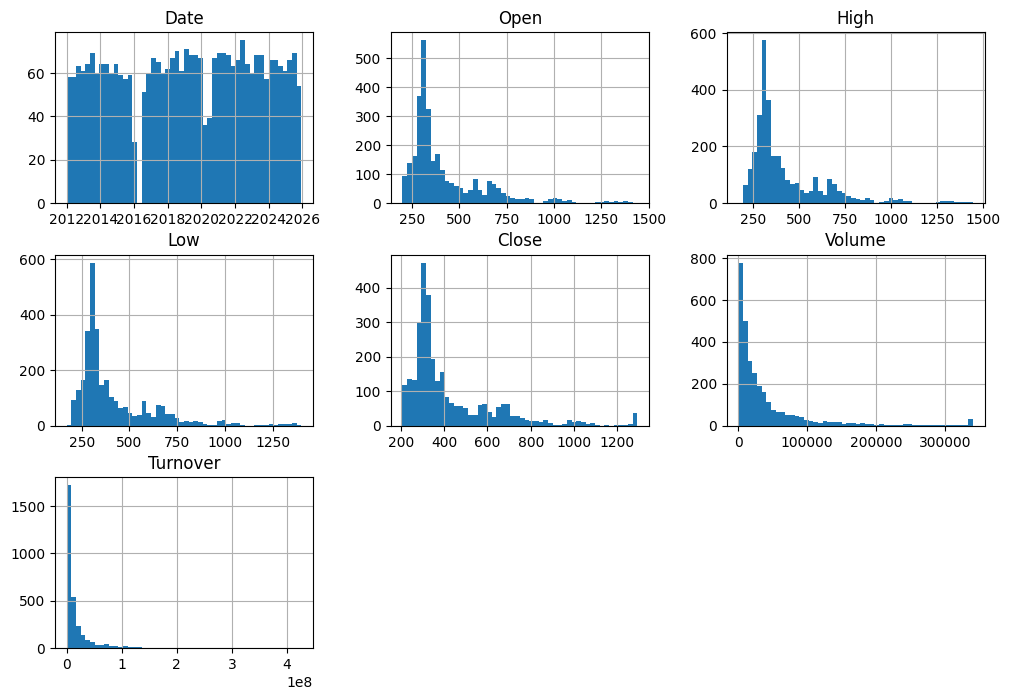

In [31]:

df.hist(bins=50, figsize=(12,8))
plt.show()

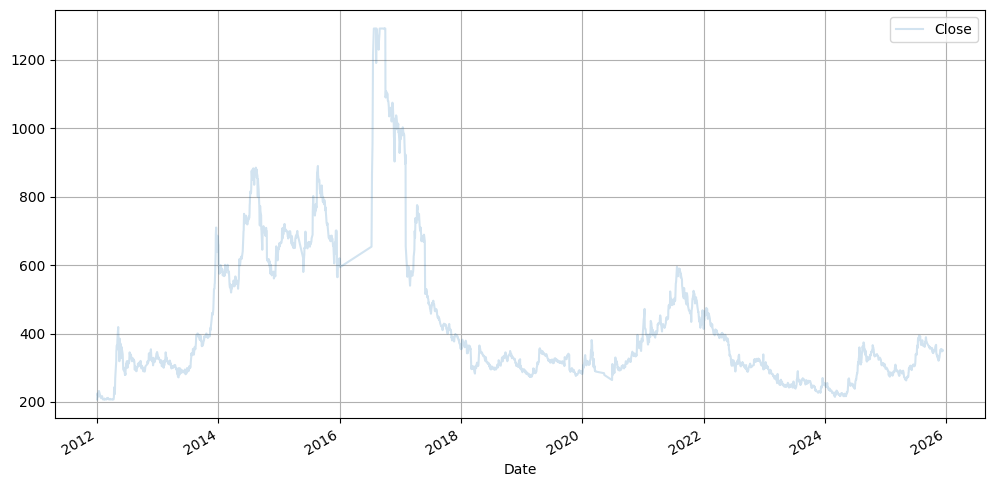

In [32]:
df.plot(kind="line", x="Date",y="Close", grid=True, alpha=0.2, figsize=(12, 6))
plt.show()

In [33]:
print("\nEngineering features...")
df = compute_selected_indicators(df)

FEATURES = [
    'Close', 'Open', 'High', 'Low',  # Price
    'Volume_norm', 'OBV_norm',  # Volume
    'Return', 'Return_lag1', 'Return_lag2', 'Return_lag5',  # Momentum
    'EMA12', 'EMA26', 'SMA50',  # Trend (no overlap)
    'RSI', 'BB_position',  # Oscillators
    'MACD_hist',  # MACD (just histogram, most informative)
    'Volatility', 'ATR_norm',  # Volatility
    'ROC', 'Price_position'  # Additional momentum
]

FEATURES = [f for f in FEATURES if f in df.columns]
CLOSE_IDX = FEATURES.index('Close')

df = df[FEATURES + ['Date']].dropna().reset_index(drop=True)
print(f"After feature engineering: {len(df)} rows, {len(FEATURES)} features")
print(f"Features: {FEATURES}")


Engineering features...
After feature engineering: 3039 rows, 20 features
Features: ['Close', 'Open', 'High', 'Low', 'Volume_norm', 'OBV_norm', 'Return', 'Return_lag1', 'Return_lag2', 'Return_lag5', 'EMA12', 'EMA26', 'SMA50', 'RSI', 'BB_position', 'MACD_hist', 'Volatility', 'ATR_norm', 'ROC', 'Price_position']


In [34]:
# -------------------------
# Split Data
# -------------------------
n = len(df)
if n < 500:
    raise ValueError("Need at least 500 rows of data for reliable training")

test_start = int(n * (1 - TEST_PCT))
train_end = int(test_start * (1 - VAL_WITHIN_TRAIN_PCT))
val_start = train_end

print(f"\nData splits:")
print(f"  Train: {train_end} rows")
print(f"  Val:   {test_start - train_end} rows")
print(f"  Test:  {n - test_start} rows")

raw_data = df[FEATURES].values.astype(np.float32)

scaler = RobustScaler()
scaler.fit(raw_data[:train_end])
scaled_all = scaler.transform(raw_data)



Data splits:
  Train: 2461 rows
  Val:   274 rows
  Test:  304 rows


In [35]:
print("\nCreating sequences...")

def create_sequences(data, seq_len, close_idx):
    X, y, idx = [], [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, close_idx])
        idx.append(i)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(idx)

X_all, y_all, seq_idx = create_sequences(scaled_all, SEQ_LEN, CLOSE_IDX)

train_mask = seq_idx < train_end
val_mask = (seq_idx >= val_start) & (seq_idx < test_start)
test_mask = seq_idx >= test_start

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val, y_val = X_all[val_mask], y_all[val_mask]
X_test, y_test = X_all[test_mask], y_all[test_mask]

print(f"Sequences - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Creating sequences...
Sequences - Train: 2401, Val: 274, Test: 304


In [36]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ScratchLSTM(Layer):
    def __init__(self, units, return_sequences=False,
                 recurrent_dropout=0.0,
                 kernel_regularizer=None,
                 **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.recurrent_dropout = recurrent_dropout
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.W = self.add_weight(
            shape=(input_dim, 4 * self.units),
            initializer="glorot_uniform",
            regularizer=self.kernel_regularizer,
            trainable=True
        )

        self.U = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer="orthogonal",
            regularizer=self.kernel_regularizer,
            trainable=True
        )

        self.b = self.add_weight(
            shape=(4 * self.units,),
            initializer="zeros",
            trainable=True
        )

        super().build(input_shape)

    def step(self, x_t, states):
        h, c = states

        if self.recurrent_dropout > 0:
            h = tf.nn.dropout(h, rate=self.recurrent_dropout)

        z = tf.matmul(x_t, self.W) + tf.matmul(h, self.U) + self.b
        f, i, g, o = tf.split(z, 4, axis=1)

        # ----- LSTM GATE EQUATIONS -----
        f = tf.sigmoid(f)          # forget gate
        i = tf.sigmoid(i)          # input gate
        g = tf.tanh(g)             # candidate
        o = tf.sigmoid(o)          # output gate

        c = f * c + i * g          # cell state
        h = o * tf.tanh(c)         # hidden state
        # --------------------------------

        return h, [h, c]

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        h0 = tf.zeros((batch_size, self.units))
        c0 = tf.zeros((batch_size, self.units))

        last_output, outputs, states = K.rnn(
            self.step,
            inputs,
            [h0, c0]
        )

        return outputs if self.return_sequences else last_output


In [37]:

model = Sequential([
    ScratchLSTM(84, return_sequences=True, 
         recurrent_dropout=0.2,
         kernel_regularizer=regularizers.l2(0.001),
         input_shape=(SEQ_LEN, len(FEATURES))),
    Dropout(0.3),
     
    LSTM(42, recurrent_dropout=0.2,
         kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ scratch_lstm_3 (ScratchLSTM)    │ (None, 60, 84)         │        35,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 84)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 42)             │        21,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,659 (221.32 KB)

 Trainable params: 56,659 (221.32 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
%matplotlib inline
print("\nTraining...")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1, min_lr=1e-7)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    shuffle=False,
    verbose=1
)

# Plot training
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Training History')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(symbol_dir, f"{symbol}_training.png"), dpi=100)
plt.close()


Training...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - loss: 0.3855 - mae: 0.2524 - val_loss: 0.1763 - val_mae: 0.1232 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.2297 - mae: 0.1532 - val_loss: 0.1248 - val_mae: 0.0952 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.1615 - mae: 0.1408 - val_loss: 0.1007 - val_mae: 0.0818 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.1465 - mae: 0.1280 - val_loss: 0.0840 - val_mae: 0.0880 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.1139 - mae: 0.1140 - val_loss: 0.0688 - val_mae: 0.0662 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0887 - mae: 0.0991 - val_loss: 0.0550 - val_mae: 0.0247 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0947 - mae: 0.1263 - val_loss: 0.0660 - val_mae: 0.1236 - learning_rate:

In [39]:
print("\n" + "="*60)
print("Evaluating on test set...")
print("="*60)

def inverse_transform_close(scaled_vals, scaler, close_idx):
    """Inverse transform close prices"""
    arr = np.asarray(scaled_vals).flatten()
    out = np.zeros((len(arr), len(FEATURES)), dtype=np.float32)
    out[:, close_idx] = arr
    return scaler.inverse_transform(out)[:, close_idx]

y_test_pred_scaled = model.predict(X_test, batch_size=64, verbose=0).flatten()

y_test_actual = inverse_transform_close(y_test, scaler, CLOSE_IDX)
y_test_pred = inverse_transform_close(y_test_pred_scaled, scaler, CLOSE_IDX)

# Regression metrics
mae = mean_absolute_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mape = np.mean(np.abs((y_test_actual - y_test_pred) / (y_test_actual + 1e-9))) * 100
r2 = r2_score(y_test_actual, y_test_pred)

print(f"\nRegression Metrics:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²:   {r2:.4f}")



Evaluating on test set...

Regression Metrics:
  MAE:  4.93
  RMSE: 6.86
  MAPE: 1.48%
  R²:   0.9577


In [40]:
test_indices = seq_idx[test_mask]
prev_close = df['Close'].iloc[np.maximum(test_indices - 1, 0)].values

# absolute & percent errors
abs_error = np.abs(y_test_pred - y_test_actual)
pct_error = abs_error / (np.abs(y_test_actual) + 1e-9)

# volatility-based percent threshold (if enabled)
if USE_VOLATILITY_SCALE:
    lookback = min(len(df), VOL_LOOKBACK)
    daily_vol = df['Close'].pct_change().iloc[-lookback:].std()
    vol_pct_threshold = max(1e-6, daily_vol * VOL_MULTIPLIER)  # at least tiny positive
else:
    vol_pct_threshold = None

# select threshold
if USE_PERCENT_THRESHOLD:
    if vol_pct_threshold is not None:
        threshold_pct = vol_pct_threshold
    else:
        threshold_pct = PCT_THRESHOLD
    within_tol_pct_mask = pct_error <= threshold_pct
    threshold_info = f"{threshold_pct*100:.2f}%"
else:
    within_tol_pct_mask = None
    threshold_info = f"{ABS_THRESHOLD:.2f} absolute units"
    within_tol_abs_mask = abs_error <= ABS_THRESHOLD

# choose primary within_tol_mask depending on configuration
if USE_PERCENT_THRESHOLD:
    within_tol_mask = within_tol_pct_mask
else:
    within_tol_mask = within_tol_abs_mask

tolerance_accuracy = within_tol_mask.mean() if len(within_tol_mask) > 0 else 0.0

# direction match mask (same as classification direction)
dir_actual = np.where((y_test_actual - prev_close) >= 0, 'UP', 'DOWN')
dir_pred = np.where((y_test_pred - prev_close) >= 0, 'UP', 'DOWN')
dir_match_mask = dir_actual == dir_pred
direction_accuracy = dir_match_mask.mean()

# hybrid: direction match OR within tolerance
hybrid_mask = dir_match_mask | within_tol_mask
hybrid_accuracy = hybrid_mask.mean()

print("\nTolerance-based correctness:")
if USE_PERCENT_THRESHOLD:
    print(f"  Using percent threshold: {threshold_info}")
else:
    print(f"  Using absolute threshold: {threshold_info}")
if vol_pct_threshold is not None and USE_PERCENT_THRESHOLD:
    print(f"  Volatility-based pct threshold (daily vol * multiplier): {vol_pct_threshold*100:.2f}%")
print(f"  Tolerance-based accuracy: {tolerance_accuracy:.4f} ({tolerance_accuracy*100:.2f}%)")
print(f"  Direction-only accuracy:  {direction_accuracy:.4f} ({direction_accuracy*100:.2f}%)")
print(f"  Hybrid accuracy (dir OR within tol): {hybrid_accuracy:.4f} ({hybrid_accuracy*100:.2f}%)")



Tolerance-based correctness:
  Using percent threshold: 1.52%
  Volatility-based pct threshold (daily vol * multiplier): 1.52%
  Tolerance-based accuracy: 0.6612 (66.12%)
  Direction-only accuracy:  0.5197 (51.97%)
  Hybrid accuracy (dir OR within tol): 0.7171 (71.71%)


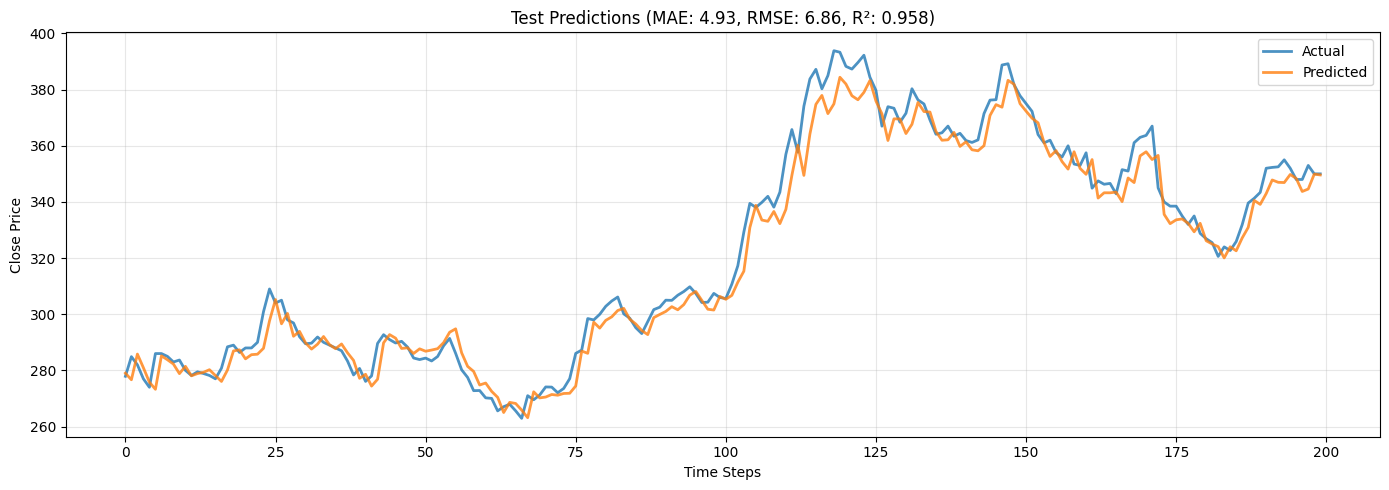

In [41]:
%matplotlib inline
plt.figure(figsize=(14, 5))
plot_n = min(200, len(y_test_actual))
x_range = range(plot_n)

plt.plot(x_range, y_test_actual[-plot_n:], label='Actual', linewidth=2, alpha=0.8)
plt.plot(x_range, y_test_pred[-plot_n:], label='Predicted', linewidth=2, alpha=0.8)

plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.title(f'Test Predictions (MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# SAVE the image
save_path = os.path.join(symbol_dir, f"{symbol}_predictions.png")
plt.savefig(save_path, dpi=100)

# DISPLAY the image
plt.show()

# Finally close the figure (optional but clean)
plt.close()


In [42]:
# -------------------------
# Classification (FIXED with binary and adaptive tolerance)
# -------------------------
print("\n" + "="*60)
print("Direction Classification...")
print("="*60)

# we already computed test_indices & prev_close earlier
actual_change = (y_test_actual - prev_close) / (prev_close + 1e-9)
pred_change = (y_test_pred - prev_close) / (prev_close + 1e-9)

# Calculate adaptive tolerance from recent volatility (for direction UNCHANGED if ternary)
recent_volatility = df['Close'].iloc[-200:].pct_change().std()
tolerance = recent_volatility * TOLERANCE_MULTIPLIER

print(f"Volatility: {recent_volatility:.4f}")
print(f"Tolerance:  {tolerance:.4f} ({tolerance*100:.2f}%)")

def classify_direction(changes, tol, binary=True):
    """Classify price movements"""
    if binary:
        # Binary: UP if change >= 0, DOWN otherwise
        return np.where(changes >= 0, 'UP', 'DOWN')
    else:
        # Ternary with tolerance
        return np.where(changes > tol, 'UP',
                       np.where(changes < -tol, 'DOWN', 'UNCHANGED'))

actual_labels = classify_direction(actual_change, tolerance, USE_BINARY_CLASSIFICATION)
pred_labels = classify_direction(pred_change, tolerance, USE_BINARY_CLASSIFICATION)

# Count distribution
unique_actual, counts_actual = np.unique(actual_labels, return_counts=True)
unique_pred, counts_pred = np.unique(pred_labels, return_counts=True)

print(f"\nActual distribution: {dict(zip(unique_actual, counts_actual))}")
print(f"Predicted distribution: {dict(zip(unique_pred, counts_pred))}")

# Metrics
labels_list = ['UP', 'DOWN'] if USE_BINARY_CLASSIFICATION else ['UP', 'DOWN', 'UNCHANGED']
acc = accuracy_score(actual_labels, pred_labels)

prec, rec, f1, _ = precision_recall_fscore_support(
    actual_labels, pred_labels, labels=labels_list, average='weighted', zero_division=0)

print(f"\nClassification Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"Weighted Precision: {prec:.4f}")
print(f"Weighted Recall:    {rec:.4f}")
print(f"Weighted F1:        {f1:.4f}")

# Per-class
prec_c, rec_c, f1_c, sup_c = precision_recall_fscore_support(
    actual_labels, pred_labels, labels=labels_list, zero_division=0)

print(f"\nPer-class metrics:")
for i, label in enumerate(labels_list):
    print(f"  {label:10s} -> Prec: {prec_c[i]:.3f}, Rec: {rec_c[i]:.3f}, F1: {f1_c[i]:.3f}, Support: {sup_c[i]}")

# Confusion matrix
cm = confusion_matrix(actual_labels, pred_labels, labels=labels_list)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=labels_list, yticklabels=labels_list,
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {acc:.2%}')
plt.tight_layout()
plt.savefig(os.path.join(symbol_dir, f"{symbol}_confusion.png"), dpi=100)
plt.close()


Direction Classification...
Volatility: 0.0153
Tolerance:  0.0046 (0.46%)

Actual distribution: {np.str_('DOWN'): np.int64(161), np.str_('UP'): np.int64(143)}
Predicted distribution: {np.str_('DOWN'): np.int64(265), np.str_('UP'): np.int64(39)}

Classification Accuracy: 0.5197 (51.97%)
Weighted Precision: 0.4969
Weighted Recall:    0.5197
Weighted F1:        0.4411

Per-class metrics:
  UP         -> Prec: 0.462, Rec: 0.126, F1: 0.198, Support: 143
  DOWN       -> Prec: 0.528, Rec: 0.870, F1: 0.657, Support: 161


In [43]:

# -------------------------
# Next Day Prediction
# -------------------------
print("\n" + "="*60)
print("Next Day Prediction...")
print("="*60)

last_seq = scaled_all[-SEQ_LEN:].reshape(1, SEQ_LEN, -1)
next_pred_scaled = model.predict(last_seq, verbose=0)[0, 0]
next_pred_price = inverse_transform_close([next_pred_scaled], scaler, CLOSE_IDX)[0]

last_close = df['Close'].iloc[-1]
last_date = df['Date'].iloc[-1]
next_date = last_date + pd.Timedelta(days=1)

change_amount = next_pred_price - last_close
change_pct = (change_amount / last_close) * 100
direction = 'UP' if change_amount > 0 else 'DOWN'

print(f"\nLast Date:       {last_date.date()}")
print(f"Last Close:      {last_close:.2f}")
print(f"Predicted Date:  {next_date.date()}")
print(f"Predicted Close: {next_pred_price:.2f}")
print(f"Change:          {change_amount:+.2f} ({change_pct:+.2f}%)")
print(f"Direction:       {direction}")

# Sanity check
if abs(change_pct) > 10:
    print(f"\n WARNING: Predicted change of {change_pct:+.2f}% seems extreme!")
    print("   Model may need more training data or tuning.")


Next Day Prediction...

Last Date:       2025-12-11
Last Close:      350.00
Predicted Date:  2025-12-12
Predicted Close: 349.03
Change:          -0.97 (-0.28%)
Direction:       DOWN


In [44]:

print("\n" + "="*60)
print("Saving results...")
print("="*60)

# CSV with predictions + tolerance fields
results_df = pd.DataFrame({
    'Date': df['Date'].iloc[test_indices].reset_index(drop=True),
    'Actual_Close': y_test_actual,
    'Predicted_Close': y_test_pred,
    'Error': y_test_actual - y_test_pred,
    'Error_Pct': ((y_test_actual - y_test_pred) / y_test_actual) * 100,
    'Abs_Error': abs_error,
    'Pct_Error': pct_error * 100,
    # 'Within_Tolerance_Abs': within_tol_abs_mask,
    'Within_Tolerance_Pct': (within_tol_pct_mask if within_tol_pct_mask is not None else [False]*len(abs_error)),
    'Dir_Match': dir_match_mask,
    'Hybrid_Correct': hybrid_mask,
    'Actual_Direction': actual_labels,
    'Predicted_Direction': pred_labels,
    'Correct': actual_labels == pred_labels
})
results_df.to_csv(os.path.join(symbol_dir, f"{symbol}_results_with_tol.csv"), index=False)
print(f"✓ Saved: {symbol}_results_with_tol.csv")

# Save model and scaler
model.save(os.path.join(symbol_dir, f"{symbol}_model.keras"))
joblib.dump(scaler, os.path.join(symbol_dir, f"{symbol}_scaler.pkl"))
print(f"✓ Saved: {symbol}_model.keras")
print(f"✓ Saved: {symbol}_scaler.pkl")

# Save configuration and results
results_json = {
    "symbol": symbol,
    "timestamp": datetime.datetime.utcnow().isoformat(),
    "config": {
        "seq_len": SEQ_LEN,
        "features": FEATURES,
        "num_features": len(FEATURES),
        "binary_classification": USE_BINARY_CLASSIFICATION,
        "direction_tolerance": float(tolerance),
        "test_pct": TEST_PCT,
        "tolerance_correctness": {
            "use_percent_threshold": bool(USE_PERCENT_THRESHOLD),
            "abs_threshold": float(ABS_THRESHOLD),
            "pct_threshold": float(PCT_THRESHOLD),
            "use_volatility_scale": bool(USE_VOLATILITY_SCALE),
            "vol_multiplier": float(VOL_MULTIPLIER),
            "vol_lookback": int(VOL_LOOKBACK)
        }
    },
    "regression": {
        "mae": float(mae),
        "rmse": float(rmse),
        "mape": float(mape),
        "r2": float(r2)
    },
    "classification": {
        "accuracy": float(acc),
        "weighted_precision": float(prec),
        "weighted_recall": float(rec),
        "weighted_f1": float(f1),
        "direction_accuracy": float(direction_accuracy),
        "tolerance_accuracy": float(tolerance_accuracy),
        "hybrid_accuracy": float(hybrid_accuracy)
    },
    "next_prediction": {
        "last_date": str(last_date.date()),
        "last_close": float(last_close),
        "predicted_date": str(next_date.date()),
        "predicted_close": float(next_pred_price),
        "change_amount": float(change_amount),
        "change_pct": float(change_pct),
        "direction": direction
    }
}

with open(os.path.join(symbol_dir, f"{symbol}_results.json"), "w") as f:
    json.dump(results_json, f, indent=2)
print(f"✓ Saved: {symbol}_results.json")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Regression  - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
print(f"Classification - Accuracy: {acc:.2%}, F1: {f1:.3f}")
print(f"Direction-only accuracy: {direction_accuracy:.2%}")
print(f"Tolerance-based accuracy: {tolerance_accuracy:.2%}  (threshold: {threshold_info})")
print(f"Hybrid correctness (dir OR within tol): {hybrid_accuracy:.2%}")
print(f"Next Day    - {last_close:.2f} → {next_pred_price:.2f} ({change_pct:+.2f}%)")
print("="*60)
print(f"\nAll outputs saved to: {symbol_dir}")



Saving results...
✓ Saved: SBL_results_with_tol.csv


ValueError: Invalid format specifier